In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
from entropy_bounds.utils import optimization_cf
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array



import matplotlib.pyplot as plt
import seaborn as sns
import math


In [78]:
from linearmodels.iv import IV2SLS
import statsmodels.api as sm

sim = simulate_deterministic_data_with_probabilistic_ate()

df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

# Add a constant term for the exogenous variables
df['const'] = 1  # Adding a constant column

# Define the dependent variable (Y), endogenous variable (X), exogenous variable (constant), and instrument (Z)
dependent = df['Y']
endog = df['X']
exog = df[['const']]  # Exogenous variables (constant term)
instruments = df['Z']

# Perform 2SLS regression
model = IV2SLS(dependent, exog, endog, instruments).fit()

CI_level = 0.95
# Print the results
print('ATE true:', sim['ATE_true'])
print(model.summary)
print('Coefficient for X:', model.params['X'])
print('Lower CI for X:', model.conf_int(level=CI_level).loc['X']['lower'])
print('Upper CI for X:', model.conf_int(level=CI_level).loc['X']['upper'])
print('Confidence Interval computed for 1-alpha =', CI_level)

ATE true: 0.07628450000012728
                          IV-2SLS Estimation Summary                          
Dep. Variable:                      Y   R-squared:                     -0.0336
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0357
No. Observations:                 500   F-statistic:                    6.6979
Date:                Sat, Apr 26 2025   P-value (F-stat)                0.0097
Time:                        12:17:22   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.4783     0.0844     5.6660     0.0000      0.3128      0.6437
X              0.3175 

In [175]:
CI_level = 0.90

results = []
for b_X_Y in np.arange(-5, 5, 0.01):  # Use np.arange for 0.5 steps
    sim = simulate_deterministic_data_with_probabilistic_ate(
        b_X_Y = b_X_Y
    )
    sim = simulate_deterministic_data_with_probabilistic_ate()
    df = pd.DataFrame({'Y': sim['Y'], 'X': sim['X'], 'Z': sim['Z']})

    # Add a constant term for the exogenous variables
    df['const'] = 1  # Adding a constant column

    # Define the dependent variable (Y), endogenous variable (X), exogenous variable (constant), and instrument (Z)
    dependent = df['Y']
    endog = df['X']
    exog = df[['const']]  # Exogenous variables (constant term)
    instruments = df['Z']

    # Perform 2SLS regression
    model = IV2SLS(dependent, exog, endog, instruments).fit()

    CI_lower = model.conf_int(level=CI_level).loc['X']['lower']
    CI_upper =  model.conf_int(level=CI_level).loc['X']['upper']

    CI_valid = CI_lower <= sim['ATE_true'] <= CI_upper

    result = {
        'b_X_Y': sim['b_X_Y'],
        'b_Z': sim['b_Z'],
        'b_U_X': sim['b_U_X'],
        'b_U_Y': sim['b_U_Y'],
        'entropy_Y': entropy_of_array(sim['Y']),
        'entropy_X': entropy_of_array(sim['X']),
        'entropy_Z': entropy_of_array(sim['Z']),
        'entropy_U': entropy_of_array(sim['U']),
        'corr_X_Y': np.corrcoef(sim['X'], sim['Y'])[0, 1],
        'corr_X_Z': np.corrcoef(sim['X'], sim['Z'])[0, 1],
        'corr_Y_Z': np.corrcoef(sim['Y'], sim['Z'])[0, 1],
        'ATE_true': sim['ATE_true'],
        '2SLS_estimation': model.params['X'],
        '2SLS_CI_lower': CI_lower,
        '2SLS_CI_upper': CI_upper,
        '2SLS_CI_width': CI_upper - CI_lower,
        '2SLS_CI_valid': CI_valid
    }

    results.append(result)

df_results = pd.DataFrame(results)


In [184]:
### just kick out outliers (practical)

no_outliers = df_results[(df_results['2SLS_CI_width'] < 0.5) & (df_results['2SLS_CI_width'] > -0.5)]
print('Outliers:', format(len(df_results) - len(no_outliers)))
print('Outliers %:', format((len(df_results) - len(no_outliers)) / len(df_results) * 100))
print('Average CI width:', format(no_outliers['2SLS_CI_width'].mean()))

print('Invalid observations:', format(len(no_outliers[no_outliers['2SLS_CI_valid'] == False])))

Outliers: 740
Outliers %: 74.0
Average CI width: 0.41429729923574043


In [185]:
### kick out outliers and invalids (theoretical)

valid_df = df_results.loc[df_results['2SLS_CI_valid'] == True]
invalids = df_results.loc[df_results['2SLS_CI_valid'] == False].shape[0]

print('Original df size:', df_results.shape[0])

# Fix the condition to remove outliers
no_outliers_no_invalid = valid_df[(valid_df['2SLS_CI_width'] < 0.5) & (valid_df['2SLS_CI_width'] > -0.5)]
print('Invalid CI:', invalids)
print('Invalid CI %:', format(invalids / len(df_results) * 100))
print(f'Invalid observations: {invalids} ({invalids / len(df_results) * 100:.2f}%)')
print('(Valid) Outliers:', format(len(valid_df) - len(no_outliers_no_invalid)))
print('Total fails:', format(len(df_results) - len(no_outliers_no_invalid)))
print('Total fails %:', format((len(df_results) - len(no_outliers_no_invalid)) / len(df_results) * 100))
print('Average CI width:', format(no_outliers_no_invalid['2SLS_CI_width'].mean()))

Original df size: 1000
Invalid CI: 59
Invalid CI %: 5.8999999999999995
(Valid) Outliers: 695
Total fails: 754
Total fails %: 75.4
Average CI width: 0.413203562661359


C:\Users\tmari\AppData\Local\Temp\ipykernel_12884\1875816335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers['ATE_true_smooth'] = no_outliers['ATE_true'].rolling(window=1, center=True).mean()
C:\Users\tmari\AppData\Local\Temp\ipykernel_12884\1875816335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers['2SLS_CI_lower_smooth'] = no_outliers['2SLS_CI_lower'].rolling(window=1, center=True).mean()
C:\Users\tmari\AppData\Local\Temp\ipykernel_12884\1875816335.py:4: SettingWithCopyWarn

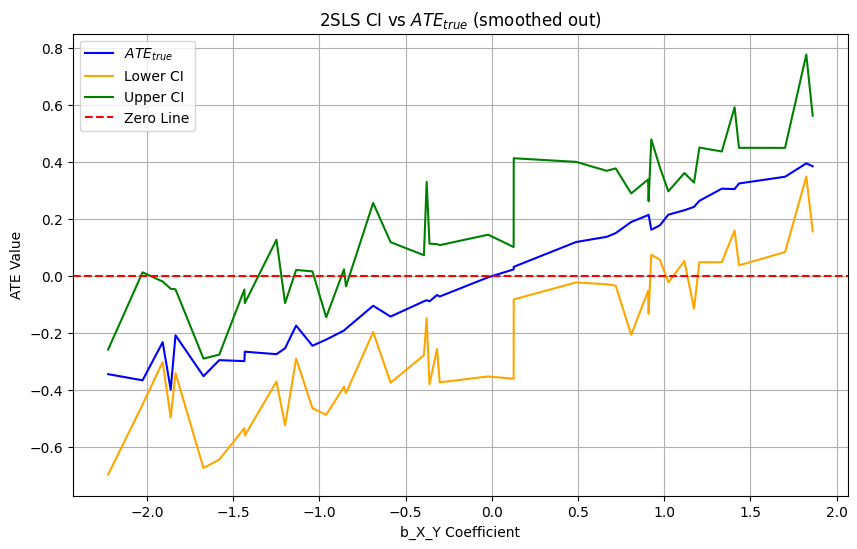

In [170]:
# Smoothen the data using a rolling average
no_outliers['ATE_true_smooth'] = no_outliers['ATE_true'].rolling(window=1, center=True).mean()
no_outliers['2SLS_CI_lower_smooth'] = no_outliers['2SLS_CI_lower'].rolling(window=1, center=True).mean()
no_outliers['2SLS_CI_upper_smooth'] = no_outliers['2SLS_CI_upper'].rolling(window=1, center=True).mean()
# Plot the smoothed data
plt.figure(figsize=(10, 6))
sns.lineplot(data=no_outliers, x='b_X_Y', y='ATE_true_smooth', label='$ATE_{true}$', color='blue')
sns.lineplot(data=no_outliers, x='b_X_Y', y='2SLS_CI_lower_smooth', label='Lower CI', color='orange')
sns.lineplot(data=no_outliers, x='b_X_Y', y='2SLS_CI_upper_smooth', label='Upper CI', color='green')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('2SLS CI vs $ATE_{true}$ (smoothed out)')
plt.xlabel('b_X_Y Coefficient')
plt.ylabel('ATE Value')
plt.legend()
plt.grid(True)
plt.show()


In [143]:
import statsmodels.api as sm

# Add a constant for the intercept
no_outliers['corr_X_Y_squared'] = no_outliers['corr_X_Y'] ** 2
no_outliers['corr_X_Z_squared'] = no_outliers['corr_X_Z'] ** 2
X = sm.add_constant(no_outliers[[ 'corr_X_Y', 'corr_X_Z',
                              'corr_X_Y_squared', 'corr_X_Z_squared', 
                              'entropy_Y', 'entropy_X']])	
y = no_outliers['2SLS_CI_width']

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

ols_robust = ols_model.get_robustcov_results(cov_type='HC1')
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          2SLS_CI_width   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     66.45
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           5.32e-08
Time:                        13:02:20   Log-Likelihood:                 28.647
No. Observations:                  18   AIC:                            -43.29
Df Residuals:                      11   BIC:                            -37.06
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.9356      0.335  

C:\Users\tmari\AppData\Local\Temp\ipykernel_12884\1182588656.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers['corr_X_Y_squared'] = no_outliers['corr_X_Y'] ** 2
C:\Users\tmari\AppData\Local\Temp\ipykernel_12884\1182588656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers['corr_X_Z_squared'] = no_outliers['corr_X_Z'] ** 2
C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fe